# Tutorial to zeolite graph distance

This tutorial illustrates the calculation of the graph distance between two zeolite structures with the supercell matching method.

This implementation was made by Daniel Schwalbe-Koda. It is compatible with the `pymatgen` and `networkx` packages. If you use this code or tutorial, please cite 

D. Schwalbe-Koda, Z. Jensen, E. Olivetti, and R. Gómez-Bombarelli. "Graph similarity drives zeolite diffusionless transformations and intergrowth." _Nature Materials_ (2019). Link: https://www.nature.com/articles/s41563-019-0486-1

## Imports

The tools we will use in this tutorial have been written and packaged by us. They are located in the `../zeograph/` directory. To access them in this tutorial, we can simply add them to the path:

In [1]:
import sys
sys.path.append('../zeograph')

And then import them all:

In [2]:
import dmeasure as dm
import supercells as sc
from structure import Zeolite

Some extra tools for visualization:

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Computing the supercell matching

### Loading crystal structures of zeolites

In this example, we will work through the lattice matching of the SOD zeolite and the CHA one. CHA has an hexagonal lattice and SOD has a cubic lattice. To compare both through our graph-theoretical analysis, we need a transformation matrix that leads to a better match between both. Let us go over this procedure.

First, we load the crystal structures. We uploaded some sample CIF files retrieved from the International Zeolite Association website. Using our tools based on `pymatgen`, we load these files:

In [4]:
SOD = Zeolite.from_file('../data/cif/SOD.cif')
CHA = Zeolite.from_file('../data/cif/CHA.cif')

As mentioned before, SOD has a cubic lattice:

In [5]:
SOD.lattice

Lattice
    abc : 8.965 8.965 8.965
 angles : 90.0 90.0 90.0
 volume : 720.528032125
      A : 8.965 0.0 5.489479277178011e-16
      B : 1.4416819554351047e-15 8.965 5.489479277178011e-16
      C : 0.0 0.0 8.965

and CHA has a hexagonal lattice:

In [6]:
CHA.lattice

Lattice
    abc : 13.675 13.675 14.767
 angles : 90.0 90.0 119.99999999999999
 volume : 2391.5396006059586
      A : 13.675 0.0 8.373522489170028e-16
      B : -6.837499999999997 11.842897396752202 8.373522489170028e-16
      C : 0.0 0.0 14.767

### Generating the transformation matrices

As discussed in the Appendix D of our paper, the implementation relies on looking for a best matching among many different transformations. First of all, we generate all transformation matrices up to a cutoff $N_\textrm{max}$, as in Eqs. D9-D11 of our SI:

In [7]:
det2matrices = sc.determinant_dict(Nmax=2)

`det2matrices` now have all transformation matrices with strictly positive determinants that can be found by using numbers between -2 and 2. The possible determinants for these matrices are the following:

In [8]:
print(det2matrices.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 30, 32])


We now have to find the determinants of the transformation matrices for each one of the zeolites. The point is to create supercells such that both structures have the same number of Si atoms inside it. This would correspond to Eq. D3 of our SI. However, as the number of determinants is limited to the list above, we have to approximate the scaling, as in Eqs. D7-8 of our SI. This corresponds to find the best possible scaling for transformations given the available determinants:

In [9]:
n_CHA, n_SOD = sc.best_scaling(
    len(CHA.silicon_atoms),
    len(SOD.silicon_atoms),
    dets_available=list(det2matrices.keys())
)

We can now observe what are the best determinants for each system:

In [10]:
print('determinant for CHA: %d' % n_CHA)
print('determinant for SOD: %d' % n_SOD)

determinant for CHA: 1
determinant for SOD: 3


### Comparing the crystal structures

Now that we have the determinant for each zeolite, we can compare the lattices for a best matching. First, we take all transformation matrices and apply them to both zeolites. Therefore, the variables `A` and `B` are actually $\hat{M}^{(A)}A$ and $\hat{M}^{(B)}B$ in the article:

In [11]:
A = det2matrices[n_CHA].reshape(-1, 3, 3) @ CHA.lattice.matrix.T
B = det2matrices[n_SOD].reshape(-1, 3, 3) @ SOD.lattice.matrix.T

Naturally, for each system, we have many possibilities:

In [12]:
print('transformations for CHA: %d' % len(A))
print('transformations for SOD: %d' % len(B))

transformations for CHA: 67704
transformations for SOD: 63792


The last step is to compare the lattices. The function `supercell.compare_lattices` already implements tensor operations to make this comparison faster. It correspond to selecting transformation matrices that minimze the discrepancy between the angles of the supercell vectors (Eqs. D12-13). In this example, we will retrieve one of such transformations.

The following command can take some time to run (~5 CPU-min).

In [13]:
i, j, dist = sc.compare_lattices(A, B)

The discrepancy is given by the variable `dist`, and it is zero:

In [14]:
print(dist)

9.024308780665983e-17


This value says we found a transformation that matches perfectly both structures. Indeed, from crystallography, we know this is possible. `i` and `j` store the indices of the transformation matrices that allow such best matching:

In [15]:
M_A = det2matrices[n_CHA][i].reshape(3, 3)
M_B = det2matrices[n_SOD][j].reshape(3, 3)

The transformation matrices are the following:

In [16]:
print(M_A)
print(M_B)

[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
[[-1  0  1]
 [-1  1 -1]
 [ 0 -1 -1]]


### Graph distance between supercells

Now, everything we have to do is to create the supercells specified by the matrices above and compare their graphs. Creating the supercells:

In [17]:
CHA.make_supercell(M_A)
SOD.make_supercell(M_B)

CHA still has the hexagonal lattice:

In [18]:
CHA.lattice

Lattice
    abc : 13.675 13.675 14.767
 angles : 90.00000000000001 90.00000000000001 119.99999999999999
 volume : 2391.5396006059586
      A : -13.675 0.0 -8.373522489170028e-16
      B : 6.837499999999997 -11.842897396752202 -8.373522489170028e-16
      C : 0.0 0.0 14.767

Now, transformed SOD also has a hexagonal lattice:

In [19]:
SOD.lattice

Lattice
    abc : 12.678424586674797 15.527835489854983 12.678424586674797
 angles : 90.0 119.99999999999999 90.00000000000001
 volume : 2161.5840963749997
      A : -8.965 0.0 8.965
      B : -8.964999999999998 8.965 -8.965
      C : -1.4416819554351047e-15 -8.965 -8.965

We can retrieve their periodic graphs by using the method `get_periodic_graph` of the `Zeolite` class. The `radius` specifies how far (in Å) to look for an oxygen atom during the nearest-neighbors search. This is necessary to create the right graph:

In [20]:
G_A = CHA.get_periodic_graph(radius=2)
G_B = SOD.get_periodic_graph(radius=2)

We can visualize such graphs:

/home/dskoda/packages/conda/envs/zeograph/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


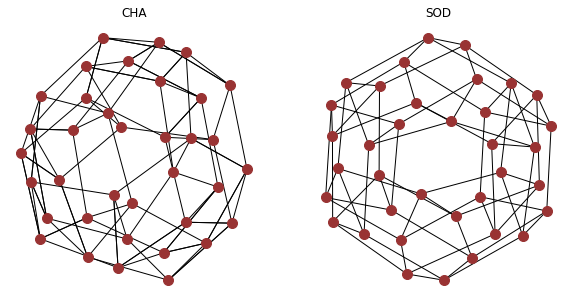

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

nx_draw_params = {
    'node_color': '#993333',
    'node_size': 100
}

nx.draw_kamada_kawai(G_A, ax=ax[0], **nx_draw_params)
nx.draw_kamada_kawai(G_B, ax=ax[1], **nx_draw_params)

ax[0].set_title('CHA')
ax[1].set_title('SOD')

plt.show()

Finally, we compute the D-measure between both graphs. The `DM_NORMALIZATION` is simply the normalization constant we used in our article to have the maximum distance between two zeolites equal to 1. The two zeolites with maximum supercell-matched graph distance are MRT-OSO.

Computing the D-measure for the CHA-SOD pair:

In [22]:
DM_NORMALIZATION = 0.4722216

print('D-measure for CHA-SOD: %.4f' % (dm.dmeasure(G_A, G_B) / DM_NORMALIZATION))

D-measure for CHA-SOD: 0.0345


The D-measure of 0.0345 is exactly the value we provided in the article.